@author: uoshvis

Data source
European Centre for Disease Prevention and Control
https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
    

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

sns.set(rc={'figure.figsize':(20,15)})


custom_date_parser = lambda x: datetime.strptime(x, "%d/%m/%Y")
df = pd.read_csv('data.csv', parse_dates=['dateRep'], date_parser=custom_date_parser)

df.rename(columns={'dateRep':'date', 'countriesAndTerritories':'country'}, inplace=True)

df.head(10)

,date,day,month,year,cases,deaths,country,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,2020-11-19,19,11,2020,0,0,Afghanistan,AF,AFG,38041757.0,Asia,5.036571
1,2020-11-18,18,11,2020,383,13,Afghanistan,AF,AFG,38041757.0,Asia,5.354642
2,2020-11-17,17,11,2020,65,6,Afghanistan,AF,AFG,38041757.0,Asia,4.573921
3,2020-11-16,16,11,2020,163,9,Afghanistan,AF,AFG,38041757.0,Asia,4.652782
4,2020-11-15,15,11,2020,205,12,Afghanistan,AF,AFG,38041757.0,Asia,4.571293
5,2020-11-14,14,11,2020,66,10,Afghanistan,AF,AFG,38041757.0,Asia,4.232191
6,2020-11-13,13,11,2020,360,14,Afghanistan,AF,AFG,38041757.0,Asia,4.471402
7,2020-11-12,12,11,2020,146,4,Afghanistan,AF,AFG,38041757.0,Asia,3.848403
8,2020-11-11,11,11,2020,0,0,Afghanistan,AF,AFG,38041757.0,Asia,3.464614
9,2020-11-10,10,11,2020,224,12,Afghanistan,AF,AFG,38041757.0,Asia,3.761656


In [4]:
countriesToSkip = ['Gibraltar', 'Guernsey', 'Holy_See', 'Isle_of_Man', 'Jersey']
countriesToSkip_2 = ['Faroe_Islands', 'San_Marino', 'Andorra', 'Monaco', 'Azerbaijan', 'Armenia']
countriesToSkip.extend(countriesToSkip_2)

df = df[df.continentExp=='Europe']
df = df[~df.country.isin(countriesToSkip)]

# change 0 cases to NaN
df.cases.replace(0, np.nan, inplace=True)

# interpolate NaN linearly
df.cases.interpolate(method='linear',inplace=True)

# fix negative cases
df['cases'] = np.where(df['cases']<0,df['cases']*(-1),df['cases'])

#calculate casesPer100k
df.loc[:, 'casesPer100k'] = df.apply(lambda row: int(round(((row.cases / row.popData2019)*100000), 0)), axis=1)

#select date range

dateStart = '2020-03-09'

df = df[df['date'].dt.date >= pd.to_datetime(dateStart).date()]

df.head()

,date,day,month,year,cases,deaths,country,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,casesPer100k
315,2020-11-19,19,11,2020,711.0,9,Albania,AL,ALB,2862427.0,Europe,263.308025,25
316,2020-11-18,18,11,2020,694.0,6,Albania,AL,ALB,2862427.0,Europe,252.303378,24
317,2020-11-17,17,11,2020,602.0,8,Albania,AL,ALB,2862427.0,Europe,241.368601,21
318,2020-11-16,16,11,2020,597.0,11,Albania,AL,ALB,2862427.0,Europe,231.551757,21
319,2020-11-15,15,11,2020,532.0,7,Albania,AL,ALB,2862427.0,Europe,222.119202,19


In [5]:
df.country.unique()

array(['Albania', 'Austria', 'Belarus', 'Belgium',
       'Bosnia_and_Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Georgia',
       'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy',
       'Kosovo', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg',
       'Malta', 'Moldova', 'Montenegro', 'Netherlands', 'North_Macedonia',
       'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 'Serbia',
       'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey',
       'Ukraine', 'United_Kingdom'], dtype=object)

In [6]:
dfn = df.loc[: ,['date', 'cases', 'country', 'popData2019']]

In [7]:
dfn = dfn.groupby([df['country'], df['date'].dt.isocalendar().week]).sum()

In [8]:
dfn.reset_index(inplace=True)

In [9]:
dfn.loc[:, 'cases100k'] = dfn.apply(lambda row: round(((row.cases / row.popData2019)*100000), 2), axis=1)


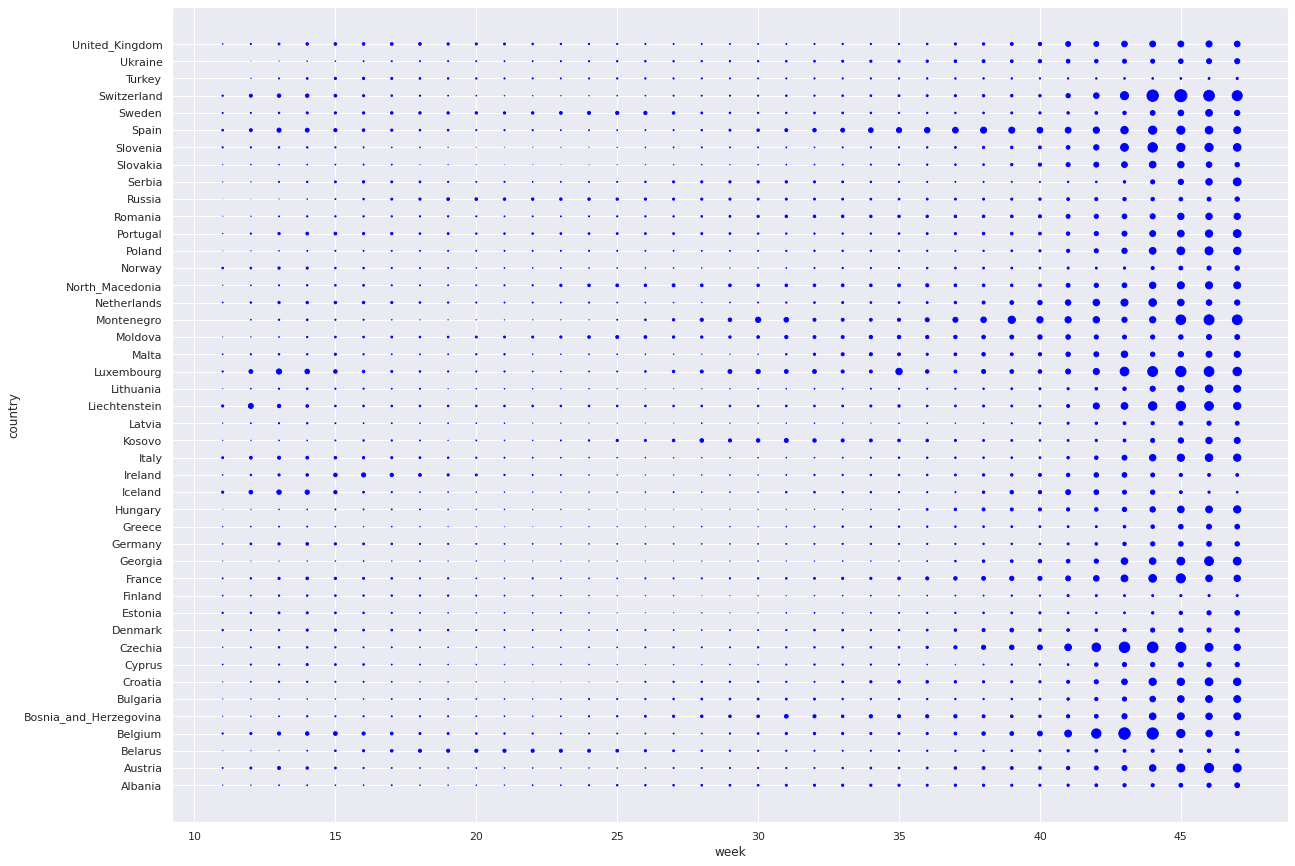

In [10]:
dfn.plot.scatter('week', 'country', s=dfn['cases100k'], color='blue');

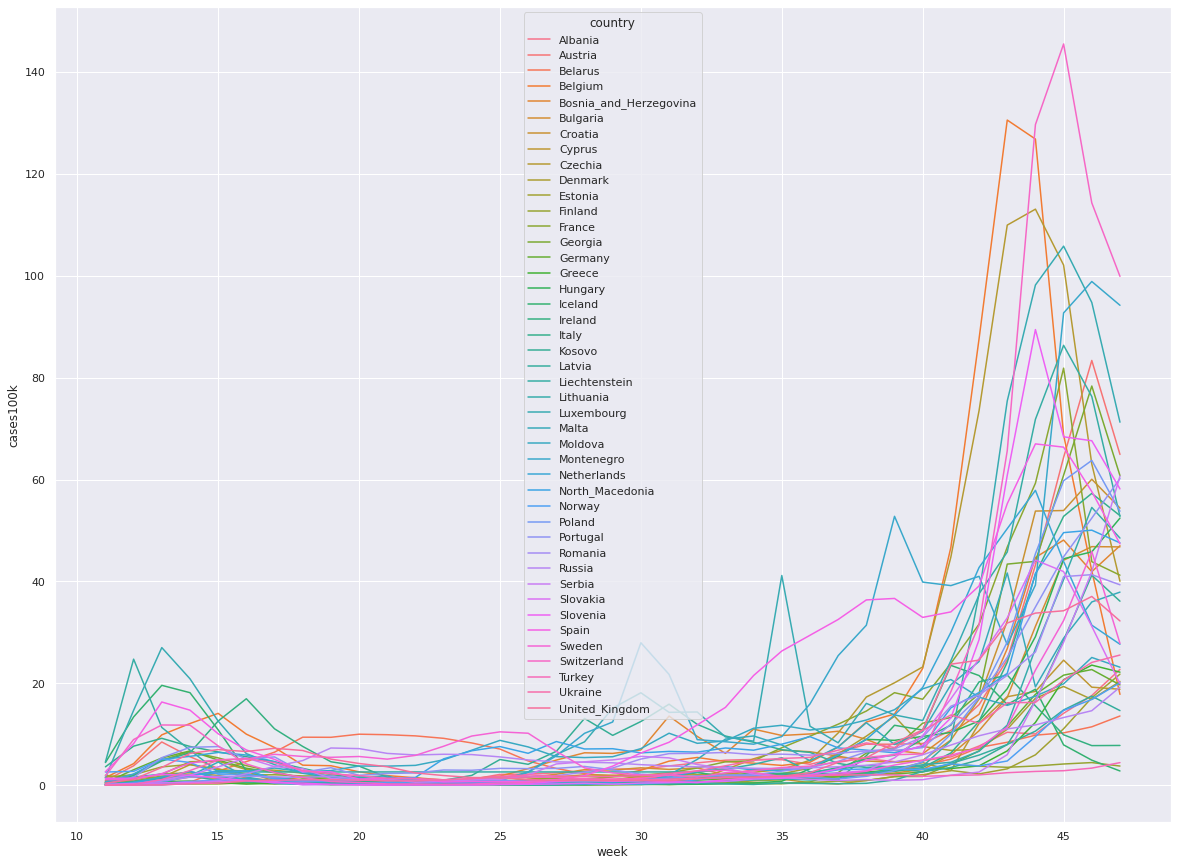

In [11]:
sns.lineplot(data=dfn, x='week', y='cases100k', hue='country', legend=True);

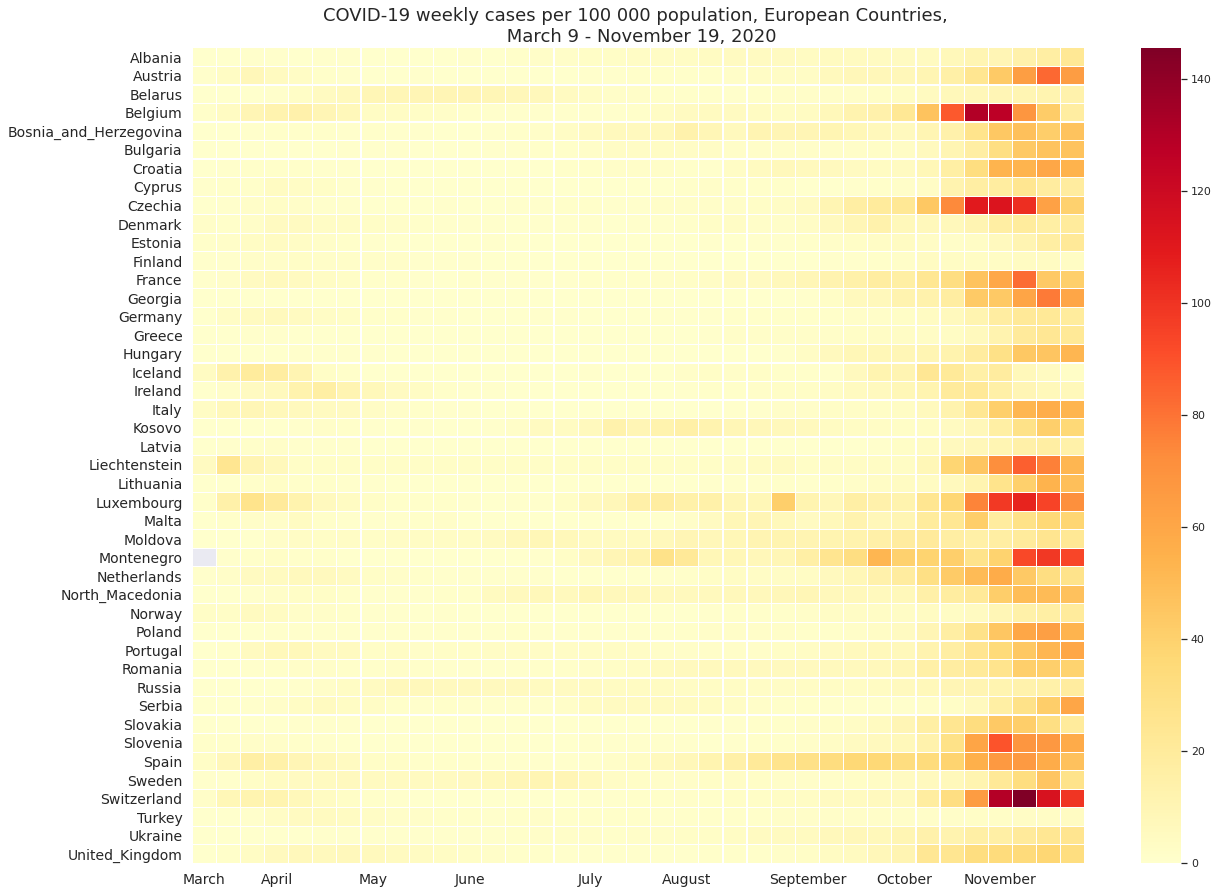

In [13]:
plt.tight_layout()

result = dfn.pivot(index='country', columns='week', values='cases100k')

ax = sns.heatmap(result,
                cmap='YlOrRd',
                linewidths=.2,
                )
plt.xlabel('', fontsize=14)
plt.ylabel('')
ax.tick_params(labelsize=14)
plt.title('COVID-19 weekly cases per 100 000 population, European Countries, \n March 9 - November 19, 2020',fontsize=18)


def to_month(week):
    d = "2020-W"+str(week)
    r = datetime.strptime(d + '-1', "%Y-W%W-%w")
    monthName = datetime.strftime(r, '%B')
    return monthName

labels = [item.get_text() for item in ax.get_xticklabels()]
labelsNew = [to_month(label) for label in labels]

labelSet = set(labelsNew)
labelsFin = [None]* len(labelsNew)
for i, label in enumerate(labelsNew):
    if label in labelSet:
        labelsFin[i] = label
        labelSet.remove(label)
    else:
        labelsFin[i] = ''

ax.set_xticklabels(labelsFin)

plt.show()